# Interfacing pytorch models with collections of AnnData objects

**Author:** [Sergei Rybakov](https://github.com/koncopd)

* This tutorial uses `AnnLoader` in combination with `AnnCollection` to interface pytorch models, aimed at training models at the scale of many AnnData objects.
* For basic usage of the AnnLoader and AnnCollection classes, please see their respective tutorials.

In [1]:
import gdown
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
import numpy as np
import scanpy as sc
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from anndata.experimental.multi_files import AnnCollection
from anndata.experimental.pytorch import AnnLoader
import warnings
warnings.simplefilter(action="ignore", category=pd.core.common.SettingWithCopyWarning)

## VAE model definition

In [2]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, out_dim):
        super().__init__()
        
        modules = []
        for in_size, out_size in zip([input_dim]+hidden_dims, hidden_dims):
            modules.append(nn.Linear(in_size, out_size))
            modules.append(nn.LayerNorm(out_size))
            modules.append(nn.ReLU())
            modules.append(nn.Dropout(p=0.05))
        modules.append(nn.Linear(hidden_dims[-1], out_dim))
        self.fc = nn.Sequential(*modules)
    
    def forward(self, *inputs):
        shape = dist.util.broadcast_shape(*[s.shape[:-1] for s in inputs]) + (-1,)
        inputs = [s.expand(shape) for s in inputs]
        
        input_cat = torch.cat(inputs, dim=-1)
        return self.fc(input_cat)

This model is a bit different from the model in the AnnLoader tutorial. Here the counts variable `X` depends on the class labels `Class` not only through the latent variable `Z` but also directly.This makes this model semi-supervised. 

<img src="./_static/semisup_cvae.jpg" width="200px">

In [3]:
# The code is based on the scarches trvae model
# https://github.com/theislab/scarches/blob/v0.3.5/scarches/models/trvae/trvae.py
# and on the pyro.ai Variational Autoencoders tutorial
# http://pyro.ai/examples/vae.html
# and the Semi-Supervised VAE tutorial
# http://pyro.ai/examples/ss-vae.html
class CVAE(nn.Module):
    def __init__(self, input_dim, n_conds, n_classes, hidden_dims, latent_dim, classifier_dims=[128]):
        super().__init__()
        
        self.encoder = MLP(input_dim+n_conds, hidden_dims, 2*latent_dim) # output - mean and logvar of z
        
        self.decoder = MLP(latent_dim+n_conds+n_classes, hidden_dims[::-1], input_dim)
        self.theta = nn.Linear(n_conds, input_dim, bias=False)
        
        self.classifier = MLP(latent_dim, classifier_dims, n_classes)
        
        self.latent_dim = latent_dim
    
    def model(self, x, batches, classes, size_factors, supervised):
        pyro.module("cvae", self)
        
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc = x.new_zeros((batch_size, self.latent_dim))
            z_scale = x.new_ones((batch_size, self.latent_dim))
            z = pyro.sample("Z", dist.Normal(z_loc, z_scale).to_event(1))
            
            classes_probs = self.classifier(z).softmax(dim=-1)
            if supervised:
                obs = classes
            else:
                obs = None
            classes = pyro.sample("Class", dist.OneHotCategorical(probs=classes_probs), obs=obs)
            
            dec_mu = self.decoder(z, batches, classes).softmax(dim=-1) * size_factors[:, None]
            dec_theta = torch.exp(self.theta(batches))
            
            logits = (dec_mu + 1e-6).log() - (dec_theta + 1e-6).log()
            
            pyro.sample("X", dist.NegativeBinomial(total_count=dec_theta, logits=logits).to_event(1), obs=x.int())
        
    def guide(self, x, batches, classes, size_factors, supervised):
        batch_size = x.shape[0]
        
        with pyro.plate("data", batch_size):
            z_loc_scale = self.encoder(x, batches)
            
            z_mu = z_loc_scale[:, :self.latent_dim]
            z_var = torch.sqrt(torch.exp(z_loc_scale[:, self.latent_dim:]) + 1e-4)
            
            z = pyro.sample("Z", dist.Normal(z_mu, z_var).to_event(1))
            
            if not supervised:
                classes_probs = self.classifier(z).softmax(dim=-1)
                pyro.sample("Class", dist.OneHotCategorical(probs=classes_probs))

## Create AnnCollection from two AnnData objects

The data is from this [scvi reproducibility notebook](https://yoseflab.github.io/scvi-tools-reproducibility/scarches_totalvi_seurat_data/).

In [4]:
gdown.download(url="https://drive.google.com/uc?id=1X5N9rOaIqiGxZRyr1fyZ6NpDPeATXoaC", 
               output="pbmc_seurat_v4.h5ad", quiet=False)
gdown.download(url="https://drive.google.com/uc?id=1JgaXNwNeoEqX7zJL-jJD3cfXDGurMrq9", 
               output="covid_cite.h5ad", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1X5N9rOaIqiGxZRyr1fyZ6NpDPeATXoaC
To: C:\Users\sergei.rybakov\projects\anndata-tutorials\pbmc_seurat_v4.h5ad
100%|█████████████████████████████████████████████████████████████████████████████| 1.00G/1.00G [00:47<00:00, 21.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JgaXNwNeoEqX7zJL-jJD3cfXDGurMrq9
To: C:\Users\sergei.rybakov\projects\anndata-tutorials\covid_cite.h5ad
100%|███████████████████████████████████████████████████████████████████████████████| 304M/304M [00:13<00:00, 22.2MB/s]


'covid_cite.h5ad'

In [5]:
covid = sc.read('covid_cite.h5ad')
pbmc = sc.read('pbmc_seurat_v4.h5ad')

In [6]:
covid

AnnData object with n_obs × n_vars = 57669 × 33538
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num'
    obsm: 'pro_exp'

In [7]:
pbmc

AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'nCount_ADT', 'nFeature_ADT', 'nCount_RNA', 'nFeature_RNA', 'orig.ident', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index'
    obsm: 'protein_counts'

In [8]:
sc.pp.highly_variable_genes(
    pbmc,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="orig.ident",
    subset=True,
)

In [9]:
dataset = AnnCollection(
    {'covid': covid, 'pbmc':pbmc},
    join_vars='inner',
    join_obs='outer',
    join_obsm='inner', 
    label='dataset',
    indices_strict=False
)

In [10]:
dataset

AnnCollection object with n_obs × n_vars = 219433 × 4000
  constructed from 2 AnnData objects
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'RNA_snn_res.0.4', 'seurat_clusters', 'set', 'Resp', 'disease', 'subj_code', 'covidpt_orhealth', 'mito', 'ncount', 'nfeat', 'bust_21', 'og_clust', 'severmod_other', 'og_clusts', 'nCount_ADT', 'nFeature_ADT', 'UMAP1', 'UMAP2', 'final_clust', 'final_clust_v2', 'new_pt_id', 'Resp_og', 'final_clust_withnum', 'final_clust_review', 'Age', 'Gender', 'Gender_num', 'lane', 'donor', 'time', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'Phase', 'nCount_SCT', 'nFeature_SCT', 'X_index', 'dataset'

In [11]:
dataset.obs['orig.ident'].loc[covid.obs_names] = covid.obs['set']

In [12]:
dataset.obs['size_factors'] = pd.Series(dtype='float32')

for batch, idx in dataset.iterate_axis(5000):
    dataset.obs['size_factors'].iloc[idx] = np.ravel(batch.X.sum(1))

In [13]:
encoder_study = OneHotEncoder(sparse=False, dtype=np.float32)
encoder_study.fit(dataset.obs['orig.ident'].to_numpy()[: , None])

OneHotEncoder(dtype=<class 'numpy.float32'>, sparse=False)

In [14]:
labels = 'celltype.l1'

In [15]:
encoder_celltype = OneHotEncoder(sparse=False, dtype=np.float32)
encoder_celltype.fit(dataset.obs[labels].to_numpy()[: , None])

OneHotEncoder(dtype=<class 'numpy.float32'>, sparse=False)

In [16]:
use_cuda = torch.cuda.is_available()

In [17]:
encoders = {
    'obs': {
        'orig.ident': lambda s: encoder_study.transform(s.to_numpy()[: , None]),
        labels: lambda c: encoder_celltype.transform(c.to_numpy()[: , None])[:, :-1]
    }
}

dataset.convert = encoders

## AnnLoader and model initialization

In [18]:
dataloader = AnnLoader(dataset, batch_size=256, shuffle=True, use_cuda=use_cuda)

In [20]:
n_conds = len(encoder_study.categories_[0])
n_classes = len(encoder_celltype.categories_[0])-1
latent_dim = 20

cvae = CVAE(dataset.shape[1], n_conds=n_conds, n_classes=n_classes, hidden_dims=[1280, 256], latent_dim=latent_dim)

if use_cuda:
    cvae.cuda()

## Train the model

In [19]:
optimizer = pyro.optim.Adam({"lr": 1e-3})

svi_sup = pyro.infer.SVI(cvae.model, cvae.guide, 
                         optimizer, loss=pyro.infer.TraceMeanField_ELBO())

# very slow for sequential
svi_unsup = pyro.infer.SVI(cvae.model, pyro.infer.config_enumerate(cvae.guide, 'parallel', expand=True), 
                           optimizer, loss=pyro.infer.TraceEnum_ELBO())

In [20]:
def train(svi_sup, svi_unsup, train_loader):
    epoch_loss = 0.
    num_correct = 0
    for batch in train_loader:
        # select indices of labelled cells
        sup_idx = batch.obs[labels].sum(1).bool().cpu().numpy()
        
        batch_sup = batch[sup_idx]
        batch_unsup = batch[~sup_idx]
        
        # do supervised step for the labelled cells
        sup_data = batch_sup.obs.to_dict(keys=['orig.ident', labels, 'size_factors'])
        sup_data['supervised'] = True
        epoch_loss += svi_sup.step(batch_sup.X, *sup_data.values())
        
        # do unsupervised step for unlabelled cells
        unsup_data = batch_unsup.obs.to_dict(keys=['orig.ident', labels, 'size_factors'])
        unsup_data['supervised'] = False
        epoch_loss += svi_unsup.step(batch_unsup.X, *unsup_data.values())

    normalizer_train = len(train_loader.dataset)
    total_epoch_loss_train = epoch_loss / normalizer_train
    return total_epoch_loss_train

In [21]:
NUM_EPOCHS = 250

for epoch in range(NUM_EPOCHS):
    total_epoch_loss_train = train(svi_sup, svi_unsup, dataloader)
    if epoch % 40 == 0 or epoch == NUM_EPOCHS-1:
        print("[epoch %03d]  average training loss: %.4f" % (epoch, total_epoch_loss_train))

[epoch 000]  average training loss: 983.3127
[epoch 040]  average training loss: 898.7591
[epoch 080]  average training loss: 895.9434
[epoch 120]  average training loss: 894.6037
[epoch 160]  average training loss: 893.6797
[epoch 200]  average training loss: 893.0895
[epoch 240]  average training loss: 892.6837
[epoch 249]  average training loss: 892.6027


## Check the results

Get means of latent variables and cell labels predictions for the unlabelled data.

In [22]:
dataset.obsm['X_cvae'] = np.empty((dataset.shape[0], latent_dim), dtype='float32')
dataset.obs['cell_type_pred'] = pd.Series(dtype=pbmc.obs[labels].dtype)

for batch, idx in dataloader.dataset.iterate_axis(5000):
    latents = cvae.encoder(batch.X, batch.obs['orig.ident'])[:, :latent_dim].detach()
    
    predict = cvae.classifier(latents).detach()
    one_hot = torch.zeros(predict.shape[0], predict.shape[1]+1, device=predict.device)
    one_hot = one_hot.scatter_(1, predict.argmax(dim=-1, keepdim=True) , 1.).cpu().numpy()
    
    dataset.obsm['X_cvae'][idx] = latents.cpu().numpy()
    dataset.obs['cell_type_pred'].iloc[idx] = np.ravel(enc_ct.inverse_transform(one_hot))

In [23]:
dataset.obs['cell_type_joint'] = dataset.obs['cell_type_pred']
dataset.obs['cell_type_joint'].loc[pbmc.obs_names]=pbmc.obs[labels]

In [24]:
adata = dataset.to_adata()

In [25]:
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)

... storing 'orig.ident' as categorical
... storing 'RNA_snn_res.0.4' as categorical
... storing 'seurat_clusters' as categorical
... storing 'set' as categorical
... storing 'Resp' as categorical
... storing 'disease' as categorical
... storing 'subj_code' as categorical
... storing 'covidpt_orhealth' as categorical
... storing 'bust_21' as categorical
... storing 'og_clust' as categorical
... storing 'severmod_other' as categorical
... storing 'og_clusts' as categorical
... storing 'final_clust' as categorical
... storing 'final_clust_v2' as categorical
... storing 'new_pt_id' as categorical
... storing 'Resp_og' as categorical
... storing 'final_clust_withnum' as categorical
... storing 'final_clust_review' as categorical
... storing 'Gender' as categorical
... storing 'lane' as categorical
... storing 'donor' as categorical
... storing 'time' as categorical
... storing 'celltype.l1' as categorical
... storing 'celltype.l2' as categorical
... storing 'celltype.l3' as categorical
...

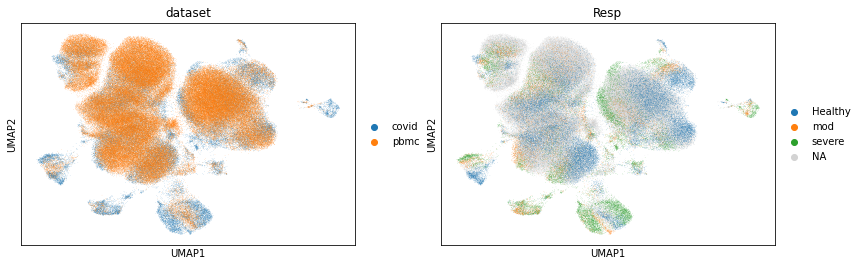

In [26]:
sc.pl.umap(adata, color=['dataset', 'Resp'])

In [27]:
accuracy = (dataset.obs['cell_type_pred'].loc[pbmc.obs_names]==pbmc.obs[labels]).sum().item()/pbmc.n_obs

In [28]:
accuracy

0.9234131203481615

Plot pbmc cell types and predicted cell types for covid.

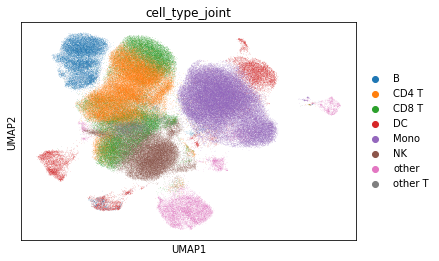

In [30]:
sc.pl.umap(adata, color='cell_type_joint')